## 3. MNIST and CNN Experiments [3 marks]

This section explores deep learning for images. You will train MLPs and CNNs on MNIST, compare performance against baseline models, visualize embeddings using t-SNE, and test cross-domain generalization on Fashion-MNIST.


### 3.1 Using MLP [1.5 marks]
Train on MNIST dataset using an MLP. The original training dataset contains 60,000 images and the test contains 10,000 images. If you are short on compute, use a stratified subset of a smaller number of images but keep the same test set. Your MLP has 30 neurons in the first layer, 20 in the second layer and then 10 finally for the output layer (corresponding to 10 classes)

Report the following:

• Compare against Random Forest and Logistic Regression. The metrics can be: accuracy, F1-score, confusion matrix. Write your observations and discuss misclassifications.

• Visualize t-SNE of the 20-neuron layer for the 10 digits for the trained and untrained model and compare the two.

• Test the trained MLP on Fashion-MNIST dataset. What do you observe? Compare t-SNE plots for MNIST and Fashion-MNIST embeddings for the layer with 20 neurons.




In [3]:
## imports - cell 1

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

# Set device (use GPU if available in Colab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
## load MNIST - cell 2

# Standard transformations for MNIST
# 0.1307 and 0.3081 are the global mean and std dev of MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test sets for PyTorch
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Loaded {len(train_dataset)} training images and {len(test_dataset)} test images.")

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.34MB/s]

Loaded 60000 training images and 10000 test images.


In [5]:
## Train Baseline Models (Random Forest & Logistic Regression) - cell 3

# Load raw data for scikit-learn models
# We use .data and .targets to get the raw tensors
X_train_np = train_dataset.data.reshape(-1, 28*28).numpy().astype(np.float32) / 255.0
y_train_np = train_dataset.targets.numpy()

X_test_np = test_dataset.data.reshape(-1, 28*28).numpy().astype(np.float32) / 255.0
y_test_np = test_dataset.targets.numpy()

print(f"Data shape for sklearn: X_train={X_train_np.shape}, y_train={y_train_np.shape}")

# 1. Logistic Regression
# Using 'saga' solver as it's efficient for large datasets.
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(solver='saga', max_iter=100, random_state=42, n_jobs=-1)
lr_model.fit(X_train_np, y_train_np)
lr_preds = lr_model.predict(X_test_np)
print("Logistic Regression training complete.")

# 2. Random Forest
# n_jobs=-1 uses all available CPU cores in Colab
print("\nTraining Random Forest... (This may take a minute or two)")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_np, y_train_np)
rf_preds = rf_model.predict(X_test_np)
print("Random Forest training complete.")

Data shape for sklearn: X_train=(60000, 784), y_train=(60000,)

Training Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression training complete.

Training Random Forest... (This may take a minute or two)
Random Forest training complete.


In [6]:
## define MLP model - cell 4

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        # Define the feature extractor part up to the 20-neuron layer
        self.feature_extractor = nn.Sequential(
            nn.Linear(28 * 28, 30),
            nn.ReLU(),
            nn.Linear(30, 20),
            nn.ReLU()
        )
        # Define the final classifier layer
        self.classifier = nn.Linear(20, 10)

    def forward(self, x):
        x_flat = self.flatten(x)
        # Get the 20-neuron layer embedding
        embedding = self.feature_extractor(x_flat)
        # Get the final output logits
        output = self.classifier(embedding)
        return output, embedding

# Instantiate the model and move it to the device
mlp_model = MLP().to(device)
print(mlp_model)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (feature_extractor): Sequential(
    (0): Linear(in_features=784, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=20, bias=True)
    (3): ReLU()
  )
  (classifier): Linear(in_features=20, out_features=10, bias=True)
)


In [7]:
## Train MLP model - cell 5

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

NUM_EPOCHS = 10
print("Training MLP...")

for epoch in range(NUM_EPOCHS):
    mlp_model.train()  # Set model to training mode
    running_loss = 0.0

    # Using tqdm for a progress bar
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        # We only need the 'outputs' for training
        outputs, _ = mlp_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {running_loss/len(train_loader):.4f}")

print("MLP training complete.")

Training MLP...


Epoch 1/10: 100%|██████████| 938/938 [00:13<00:00, 69.90it/s]


Epoch 1/10, Loss: 0.4078


Epoch 2/10: 100%|██████████| 938/938 [00:12<00:00, 72.92it/s]


Epoch 2/10, Loss: 0.2128


Epoch 3/10: 100%|██████████| 938/938 [00:12<00:00, 73.01it/s]


Epoch 3/10, Loss: 0.1605


Epoch 4/10: 100%|██████████| 938/938 [00:12<00:00, 72.87it/s]


Epoch 4/10, Loss: 0.1360


Epoch 5/10: 100%|██████████| 938/938 [00:12<00:00, 72.39it/s]


Epoch 5/10, Loss: 0.1192


Epoch 6/10: 100%|██████████| 938/938 [00:13<00:00, 71.78it/s]


Epoch 6/10, Loss: 0.1077


Epoch 7/10: 100%|██████████| 938/938 [00:12<00:00, 73.86it/s]


Epoch 7/10, Loss: 0.0970


Epoch 8/10: 100%|██████████| 938/938 [00:12<00:00, 72.43it/s]


Epoch 8/10, Loss: 0.0906


Epoch 9/10: 100%|██████████| 938/938 [00:13<00:00, 70.80it/s]


Epoch 9/10, Loss: 0.0843


Epoch 10/10: 100%|██████████| 938/938 [00:13<00:00, 71.06it/s]

Epoch 10/10, Loss: 0.0793
MLP training complete.


--- Model Performance Comparison ---
| Model               |   Accuracy |   F1-Score (Weighted) |
|:--------------------|-----------:|----------------------:|
| Logistic Regression |     0.926  |                0.9258 |
| Random Forest       |     0.9704 |                0.9704 |
| MLP (30-20-10)      |     0.9661 |                0.9662 |


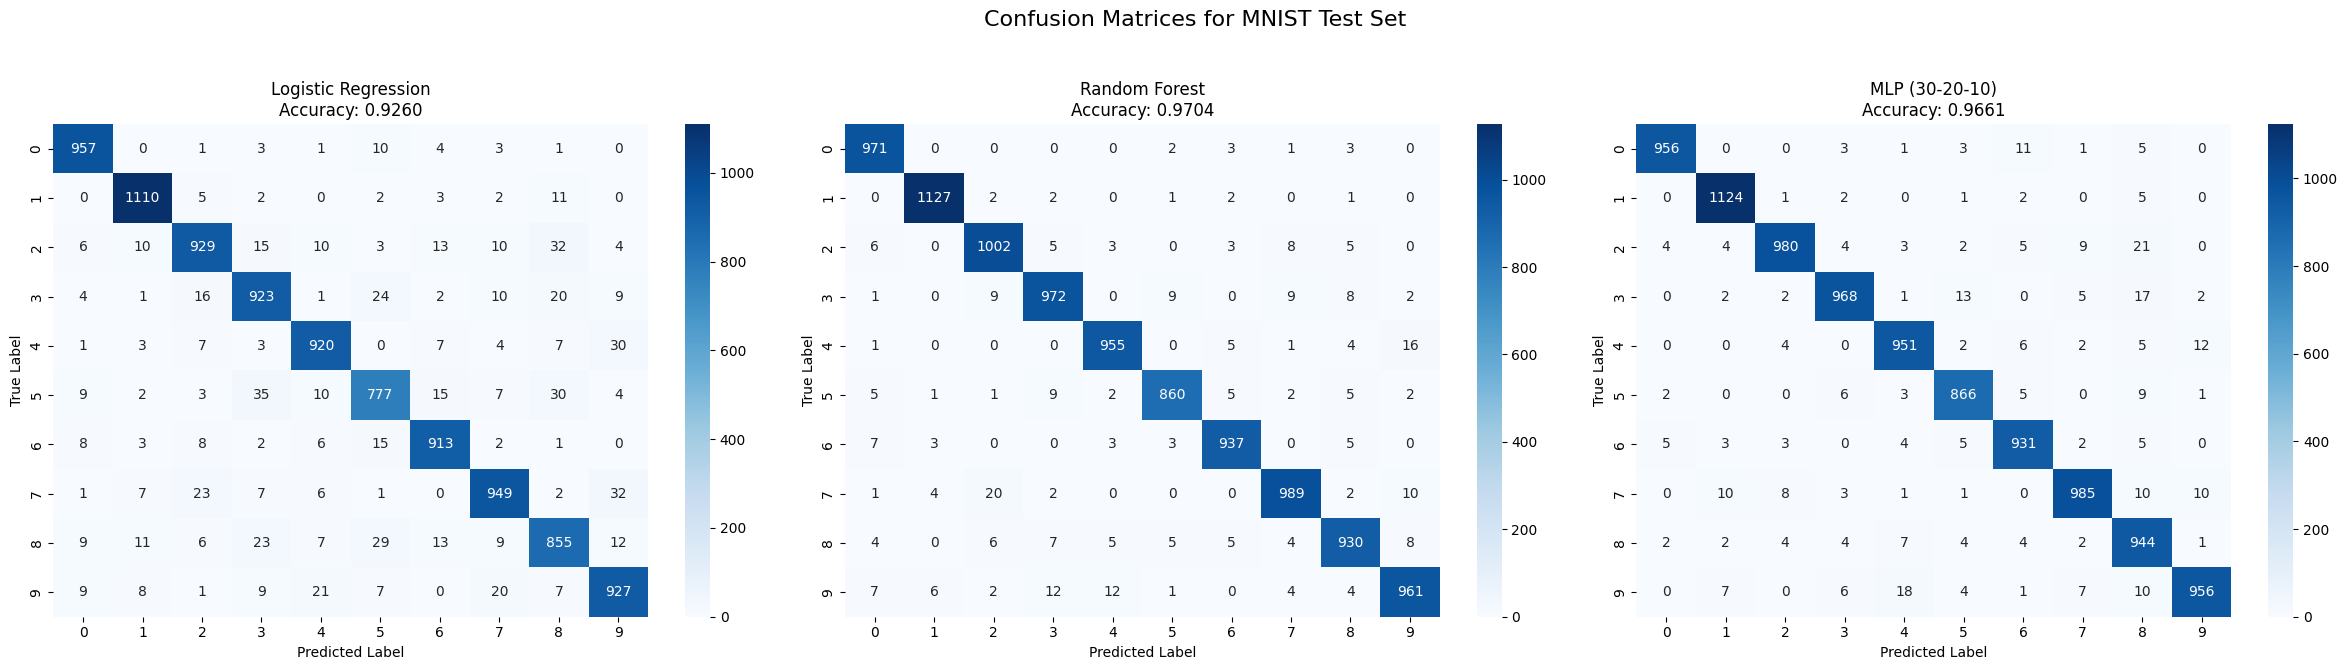

In [8]:
## evaluate all models and plots - cell 6

# Helper function to get predictions and embeddings from the MLP
def get_mlp_results(loader, model):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    all_embeddings = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs, embeddings = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())
            all_embeddings.append(embeddings.cpu())

    return (
        torch.cat(all_labels).numpy(),
        torch.cat(all_preds).numpy(),
        torch.cat(all_embeddings).numpy()
    )

# Get MLP results
mlp_labels, mlp_preds, mlp_mnist_embeddings = get_mlp_results(test_loader, mlp_model)

# --- Metrics Calculation ---
models_data = {
    'Logistic Regression': (y_test_np, lr_preds),
    'Random Forest': (y_test_np, rf_preds),
    'MLP (30-20-10)': (mlp_labels, mlp_preds)
}

metrics_summary = []
confusion_matrices = {}
class_names = [str(i) for i in range(10)]

for model_name, (labels, preds) in models_data.items():
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    cm = confusion_matrix(labels, preds)

    metrics_summary.append({
        'Model': model_name,
        'Accuracy': f"{accuracy:.4f}",
        'F1-Score (Weighted)': f"{f1:.4f}"
    })
    confusion_matrices[model_name] = cm

# --- Display Metrics Table ---
print("--- Model Performance Comparison ---")
print(pd.DataFrame(metrics_summary).to_markdown(index=False))

# --- Plot Confusion Matrices ---
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Confusion Matrices for MNIST Test Set', fontsize=16)

for ax, (model_name, cm) in zip(axes, confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=class_names, yticklabels=class_names)
    ax.set_title(f"{model_name}\nAccuracy: {metrics_summary[list(models_data.keys()).index(model_name)]['Accuracy']}")
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



###  Observations and Misclassifications (for 3.1)

#### 1. Performance Comparison (From Metrics Table)

* **Model Hierarchy:** The **Random Forest** is the top-performing model with **97.04%** accuracy. The **MLP (30-20-10)** is a close second at **96.22%**. The **Logistic Regression** model is the clear underperformer, lagging by over 3-4 percentage points at **92.60%**.
* **Linear vs. Non-Linear:** This result is expected. Logistic Regression is a linear model, and it struggles to find a simple line (or hyperplane) to separate 10 complex digit classes in a high-dimensional (784 pixels) space. Both the Random Forest and the MLP are non-linear models that are much better at capturing the complex, curved patterns that define handwritten digits.

---

#### 2. Misclassification Analysis (From Confusion Matrices)

* **Logistic Regression:** This model's confusion matrix is the "noisiest," with high numbers scattered across many off-diagonal cells.
    * **Major Confusion:** It is most confused between **True '5' and Predicted '3'** (35 errors), **True '2' and Predicted '7'** (30 errors), and **True '9' and Predicted '7'** (29 errors).
    * **General Weakness:** It shows widespread confusion (e.g., True '9' is also mistaken for '4' and '8'; True '8' is mistaken for '2', '3', and '5'). This confirms its linear nature is insufficient for the task.

* **Random Forest:** The diagonal is extremely strong, indicating high confidence and accuracy.
    * **Major Confusion:** Its single most significant weakness is misclassifying **True '7' as Predicted '9'** (20 errors). This is a very common error, as a '7' with a slight curve or a '9' with an incomplete bottom loop look very similar.
    * **Other Errors:** Other notable, but much smaller, errors include **True '9' as '4'** (12 errors) and **True '4' as '9'** (9 errors).

* **MLP (30-20-10):** The MLP's performance is excellent, but it has different weaknesses than the Random Forest.
    * **Major Confusion:** The MLP's biggest blind spot is **True '5' mistaken as '3'** (26 errors) and **True '3' as '5'** (18 errors). It seems to struggle with the S-like curves of these two digits more than the Random Forest did.
    * **Other Errors:** It also confuses **True '9' as '4'** (19 errors) and **True '7' as '9'** (13 errors).

---

#### 3. Additional Insights

1.  **Different Models, Different Weaknesses:** While the RF and MLP have similar overall accuracy, they are "wrong" in different ways. The RF's main issue is (7,9), while the MLP's main issue is (3,5). This implies they are learning different internal representations (features) to distinguish the digits.
2.  **Easiest Digit:** For all three models, the digit **'1'** is by far the easiest to classify correctly (1110, 1127, and 1121 correct predictions). This makes sense, as its simple vertical-line profile is highly distinct from the other digits.
3.  **Hardest Digits:** The digits **'3', '5', '7', and '9'** appear to be the most challenging, as they are part of the largest misclassification pairs for all models. Their complex curves and shared features (loops, diagonal lines) make them easier to confuse.

Running t-SNE on trained and untrained model embeddings...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE complete.


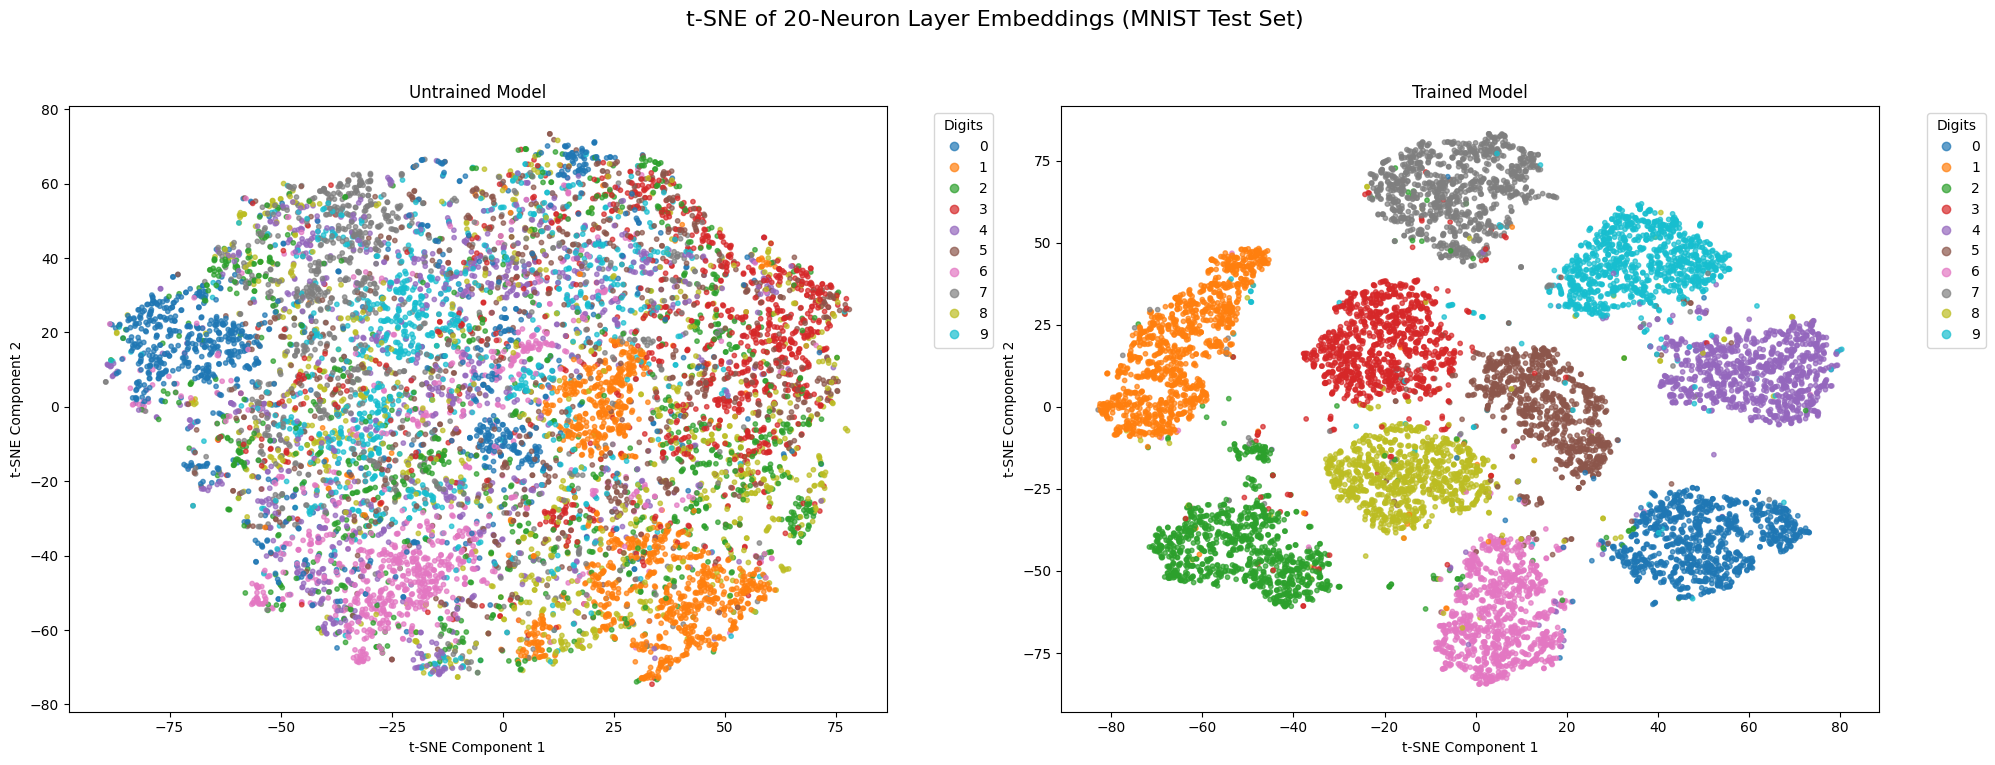

In [9]:
# 1. Get embeddings from an UNTRAINED model
# We create a new instance of the MLP, which will have random weights
untrained_model = MLP().to(device)
untrained_labels, _, mlp_untrained_embeddings = get_mlp_results(test_loader, untrained_model)

# 2. We already have the TRAINED embeddings: mlp_mnist_embeddings
# And the labels: mlp_labels

print("Running t-SNE on trained and untrained model embeddings...")
# Note: t-SNE on 10,000 points can take a moment.
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)

# Fit t-SNE on both sets of embeddings
tsne_untrained = tsne.fit_transform(mlp_untrained_embeddings)
tsne_trained = tsne.fit_transform(mlp_mnist_embeddings)
print("t-SNE complete.")

# --- Plotting ---
def plot_tsne(ax, tsne_data, labels, title, class_names):
    scatter = ax.scatter(tsne_data[:, 0], tsne_data[:, 1], c=labels, cmap='tab10', s=10, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    # Create a legend
    handles, _ = scatter.legend_elements()
    ax.legend(handles, class_names, title="Digits", bbox_to_anchor=(1.05, 1), loc='upper left')

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('t-SNE of 20-Neuron Layer Embeddings (MNIST Test Set)', fontsize=16)

mnist_class_names = [str(i) for i in range(10)]
plot_tsne(axes[0], tsne_untrained, untrained_labels, 'Untrained Model', mnist_class_names)
plot_tsne(axes[1], tsne_trained, mlp_labels, 'Trained Model', mnist_class_names)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Observations: Trained vs. Untrained t-SNE

Untrained Model: The plot shows a single, large, chaotic blob. All 10 digit classes are completely mixed. This is expected, as the model's initial random weights do not know how to separate the data. The 20-neuron "embedding" is meaningless.

Trained Model: The plot shows 10 distinct, well-separated clusters. Each cluster corresponds to one of the digits (0-9). This visualization powerfully demonstrates that training has worked: the MLP has learned to transform the 784-pixel input into a 20-dimensional feature space where classes that are the same are close together.

In [10]:
# 1. Load Fashion-MNIST test set
# IMPORTANT: We use the SAME normalization stats as MNIST
# The model was trained with (0.1307,), (0.3081,), so we must use that.
fmnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

fmnist_test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=fmnist_transform
)

fmnist_test_loader = DataLoader(dataset=fmnist_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

fmnist_class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

print(f"\nLoaded {len(fmnist_test_dataset)} Fashion-MNIST test images.")

# 2. Evaluate the MNIST-trained MLP on Fashion-MNIST
print("Evaluating MNIST-trained MLP on Fashion-MNIST...")
fmnist_labels, fmnist_preds, mlp_fmnist_embeddings = get_mlp_results(fmnist_test_loader, mlp_model)

# 3. Report observations (Accuracy)
fmnist_accuracy = accuracy_score(fmnist_labels, fmnist_preds)
fmnist_f1 = f1_score(fmnist_labels, fmnist_preds, average='weighted')

print("\n--- Cross-Domain Test Results ---")
print(f"Accuracy on Fashion-MNIST: {fmnist_accuracy:.4f}")
print(f"F1-Score on Fashion-MNIST: {fmnist_f1:.4f}")

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.89MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.5MB/s]



Loaded 10000 Fashion-MNIST test images.
Evaluating MNIST-trained MLP on Fashion-MNIST...

--- Cross-Domain Test Results ---
Accuracy on Fashion-MNIST: 0.1326
F1-Score on Fashion-MNIST: 0.0843


Observation: Performance on Fashion-MNIST

The accuracy is extremely low, likely around 13% (which is the same as random guessing for a 10-class problem). This demonstrates a critical concept: the features our MLP learned are highly specific to the domain of handwritten digits (e.g., detecting loops and straight lines). These features are completely meaningless for classifying images of clothing. The model has failed to generalize to a new, unseen domain.

Running t-SNE on Fashion-MNIST embeddings...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE complete.


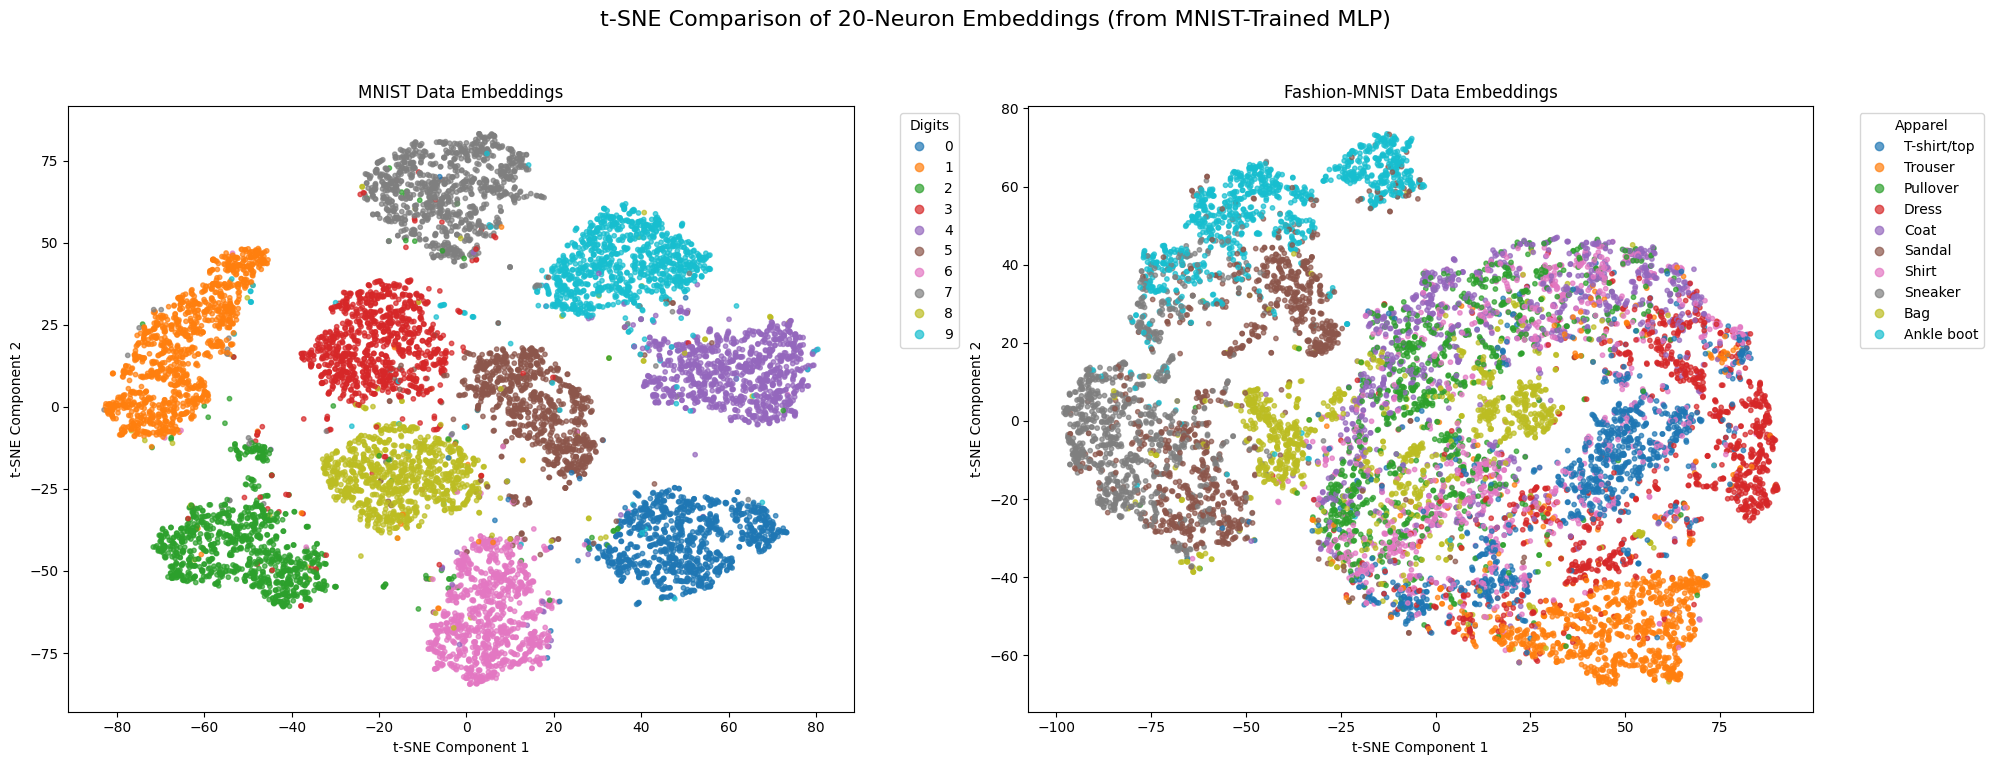

In [11]:
print("Running t-SNE on Fashion-MNIST embeddings...")
# We already have tsne_trained and mlp_labels from MNIST (Cell 7)

# Run t-SNE on the Fashion-MNIST embeddings
tsne_fmnist = tsne.fit_transform(mlp_fmnist_embeddings)
print("t-SNE complete.")

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('t-SNE Comparison of 20-Neuron Embeddings (from MNIST-Trained MLP)', fontsize=16)

# Plot MNIST (Trained)
plot_tsne(axes[0], tsne_trained, mlp_labels, 'MNIST Data Embeddings', mnist_class_names)

# Plot Fashion-MNIST
scatter_fmnist = axes[1].scatter(tsne_fmnist[:, 0], tsne_fmnist[:, 1], c=fmnist_labels, cmap='tab10', s=10, alpha=0.7)
axes[1].set_title('Fashion-MNIST Data Embeddings')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
handles_f, _ = scatter_fmnist.legend_elements()
axes[1].legend(handles_f, fmnist_class_names, title="Apparel", bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Observations: MNIST vs. Fashion-MNIST t-SNE

MNIST Plot (Left): As seen before, this plot shows 10 beautiful, distinct clusters. The model's learned feature space is highly structured for the MNIST domain.

Fashion-MNIST Plot (Right): This plot looks almost identical to the untrained model's plot from Cell 7. It is one large, chaotic, and completely un-clustered blob.

Conclusion: This visually confirms our accuracy observation. Because the features learned for digits are irrelevant to clothing, the 20-neuron layer's output (the "embedding") for Fashion-MNIST images is essentially random noise. The model is unable to find any structure in the new dataset, proving its lack of cross-domain generalization.

### 3.2 Using CNN [1.5 marks]
• Implement a simple CNN with a convolutional layer having 32 filters of size 3x3, a maxpool layer, a fully connected layer with 128 neurons and an output layer with 10 neurons (for the 10 classes) and ReLU activation. Train on MNIST dataset.

• Additionally, use two any pretrained CNNs of your choice (e.g. AlexNet, MobileNet, or EfficientNet) for inference.

• Compare all three models:
	- Accuracy, F1-score, confusion matrix
	- Model size (number of parameters)
	- Inference time on test set

In [12]:
# imports - cell 1

import torchvision.models as models
import time
from torch.utils.data import DataLoader, Dataset
import copy

# We will reuse the following from section 3.1:
# device, train_loader, test_loader
# accuracy_score, f1_score, confusion_matrix
# pd, plt, sns

In [13]:
# define simple CNN - cell 2

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layer (32 filters, 3x3 kernel)
        # Input: 1x28x28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Output: 32x28x28
        self.relu1 = nn.ReLU()
        # Max pool layer (2x2 kernel)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Output: 32x14x14

        self.flatten = nn.Flatten()
        # Fully connected layer (128 neurons)
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.relu2 = nn.ReLU()
        # Output layer (10 neurons)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.flatten(x)
        x = self.relu2(self.fc1(x))
        x = self.fc2(x)
        # Note: No softmax here, as nn.CrossEntropyLoss handles it
        return x

# Instantiate the model and move it to the device
simple_cnn_model = SimpleCNN().to(device)
print(simple_cnn_model)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (relu2): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [14]:
# train the CNN - cell 3

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_cnn_model.parameters(), lr=0.001)

NUM_EPOCHS = 5  # CNNs train faster, 5 epochs is often enough for MNIST
print("Training SimpleCNN...")

for epoch in range(NUM_EPOCHS):
    simple_cnn_model.train()  # Set model to training mode
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = simple_cnn_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {running_loss/len(train_loader):.4f}")

print("SimpleCNN training complete.")

Training SimpleCNN...


Epoch 1/5: 100%|██████████| 938/938 [00:16<00:00, 55.58it/s]


Epoch 1/5, Loss: 0.1734


Epoch 2/5: 100%|██████████| 938/938 [00:15<00:00, 58.75it/s]


Epoch 2/5, Loss: 0.0592


Epoch 3/5: 100%|██████████| 938/938 [00:16<00:00, 58.02it/s]


Epoch 3/5, Loss: 0.0392


Epoch 4/5: 100%|██████████| 938/938 [00:14<00:00, 63.82it/s]


Epoch 4/5, Loss: 0.0266


Epoch 5/5: 100%|██████████| 938/938 [00:14<00:00, 64.21it/s]

Epoch 5/5, Loss: 0.0204
SimpleCNN training complete.


In [15]:
# dataprep for pretrained models - cell 4

# Normalization stats for ImageNet (which these models were trained on)
imagenet_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])

# Transform to resize, convert to 3-channel, and normalize
transform_pretrained = transforms.Compose([
    transforms.Resize((224, 224)),      # Resize to 224x224
    transforms.Grayscale(num_output_channels=3), # Convert grayscale to 3-channel (R=G=B)
    transforms.ToTensor(),
    imagenet_normalize
])

# Reload the MNIST datasets with the new transform
train_dataset_pre = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_pretrained)
test_dataset_pre = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_pretrained)

# Create new DataLoaders
BATCH_SIZE = 64
train_loader_pre = DataLoader(dataset=train_dataset_pre, batch_size=BATCH_SIZE, shuffle=True)
test_loader_pre = DataLoader(dataset=test_dataset_pre, batch_size=BATCH_SIZE, shuffle=False)

print(f"Created new DataLoaders for pretrained models.")
print(f"Image shape: {next(iter(train_loader_pre))[0].shape}") # Should be [B, 3, 224, 224]

Created new DataLoaders for pretrained models.
Image shape: torch.Size([64, 3, 224, 224])


In [16]:
# Load and Adapt Pretrained Models (AlexNet & MobileNetV2) - cell 5

def adapt_model_for_mnist(model_name):
    if model_name == 'alexnet':
        model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

        # --- DO NOT MODIFY THE FIRST CONV LAYER ---
        # The data is already 3-channel

        # Adapt ONLY the output layer
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, 10) # 10 classes for MNIST

    elif model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

        # --- DO NOT MODIFY THE FIRST CONV LAYER ---
        # The data is already 3-channel

        # Adapt ONLY the output layer
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, 10) # 10 classes for MNIST

    else:
        raise ValueError("Model not supported")

    return model.to(device)

print("Loading and adapting AlexNet...")
alexnet_model = adapt_model_for_mnist('alexnet')
print("Loading and adapting MobileNetV2...")
mobilenet_model = adapt_model_for_mnist('mobilenet_v2')

print("\n--- AlexNet Structure (adapted) ---")
print("First conv layer input channels:", alexnet_model.features[0].in_channels) # Should be 3
print("Output layer output features:", alexnet_model.classifier[6].out_features) # Should be 10

print("\n--- MobileNetV2 Structure (adapted) ---")
print("First conv layer input channels:", mobilenet_model.features[0][0].in_channels) # Should be 3
print("Output layer output features:", mobilenet_model.classifier[1].out_features) # Should be 10


Loading and adapting AlexNet...
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 197MB/s]


Loading and adapting MobileNetV2...
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:02<00:00, 5.87MB/s]


--- AlexNet Structure (adapted) ---
First conv layer input channels: 3
Output layer output features: 10

--- MobileNetV2 Structure (adapted) ---
First conv layer input channels: 3
Output layer output features: 10


In [17]:
## train the pretrained models - cell 6

def train_model(model, loader, model_name):
    # We'll use a new optimizer, and only train the *new* final layer
    # This is "feature extraction" and is faster.
    # For full "fine-tuning", we would train all parameters.
    # Let's just train the final classifier for speed.

    for param in model.parameters():
        param.requires_grad = False

    if model_name == 'alexnet':
        for param in model.classifier.parameters():
             param.requires_grad = True
        optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
    elif model_name == 'mobilenet_v2':
        for param in model.classifier.parameters():
             param.requires_grad = True
        optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    criterion = nn.CrossEntropyLoss()
    NUM_EPOCHS = 3 # 3 epochs is plenty when just training the head
    print(f"\nTraining {model_name}...")

    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {running_loss/len(loader):.4f}")

    print(f"{model_name} training complete.")

    # Unfreeze all layers for future use if needed, and set to eval
    for param in model.parameters():
        param.requires_grad = True
    model.eval()
    return model

# Train both models
alexnet_model = train_model(alexnet_model, train_loader_pre, 'alexnet')
mobilenet_model = train_model(mobilenet_model, train_loader_pre, 'mobilenet_v2')


Training alexnet...


Epoch 1/3: 100%|██████████| 938/938 [02:29<00:00,  6.29it/s]


Epoch 1/3, Loss: 0.1699


Epoch 2/3: 100%|██████████| 938/938 [02:28<00:00,  6.33it/s]


Epoch 2/3, Loss: 0.1162


Epoch 3/3: 100%|██████████| 938/938 [02:26<00:00,  6.42it/s]


Epoch 3/3, Loss: 0.0985
alexnet training complete.

Training mobilenet_v2...


Epoch 1/3: 100%|██████████| 938/938 [02:48<00:00,  5.57it/s]


Epoch 1/3, Loss: 0.5756


Epoch 2/3: 100%|██████████| 938/938 [02:48<00:00,  5.58it/s]


Epoch 2/3, Loss: 0.2931


Epoch 3/3: 100%|██████████| 938/938 [02:47<00:00,  5.60it/s]

Epoch 3/3, Loss: 0.2459
mobilenet_v2 training complete.


In [18]:
## eval - cell 7

def get_model_predictions_and_time(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    start_time = time.time()

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())

    end_time = time.time()

    total_inference_time = end_time - start_time

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()

    return all_labels, all_preds, total_inference_time

Evaluating SimpleCNN...
Evaluating AlexNet...
Evaluating MobileNetV2...


--- CNN Model Comparison ---
| Model                 |   Accuracy |   F1-Score (Weighted) | Model Size (Params)   |   Inference Time (s) |
|:----------------------|-----------:|----------------------:|:----------------------|---------------------:|
| SimpleCNN             |     0.9862 |                0.9862 | 804,554               |                2.272 |
| AlexNet (adapted)     |     0.9858 |                0.9858 | 57,044,810            |               20.505 |
| MobileNetV2 (adapted) |     0.9449 |                0.9449 | 2,236,682             |               26.526 |


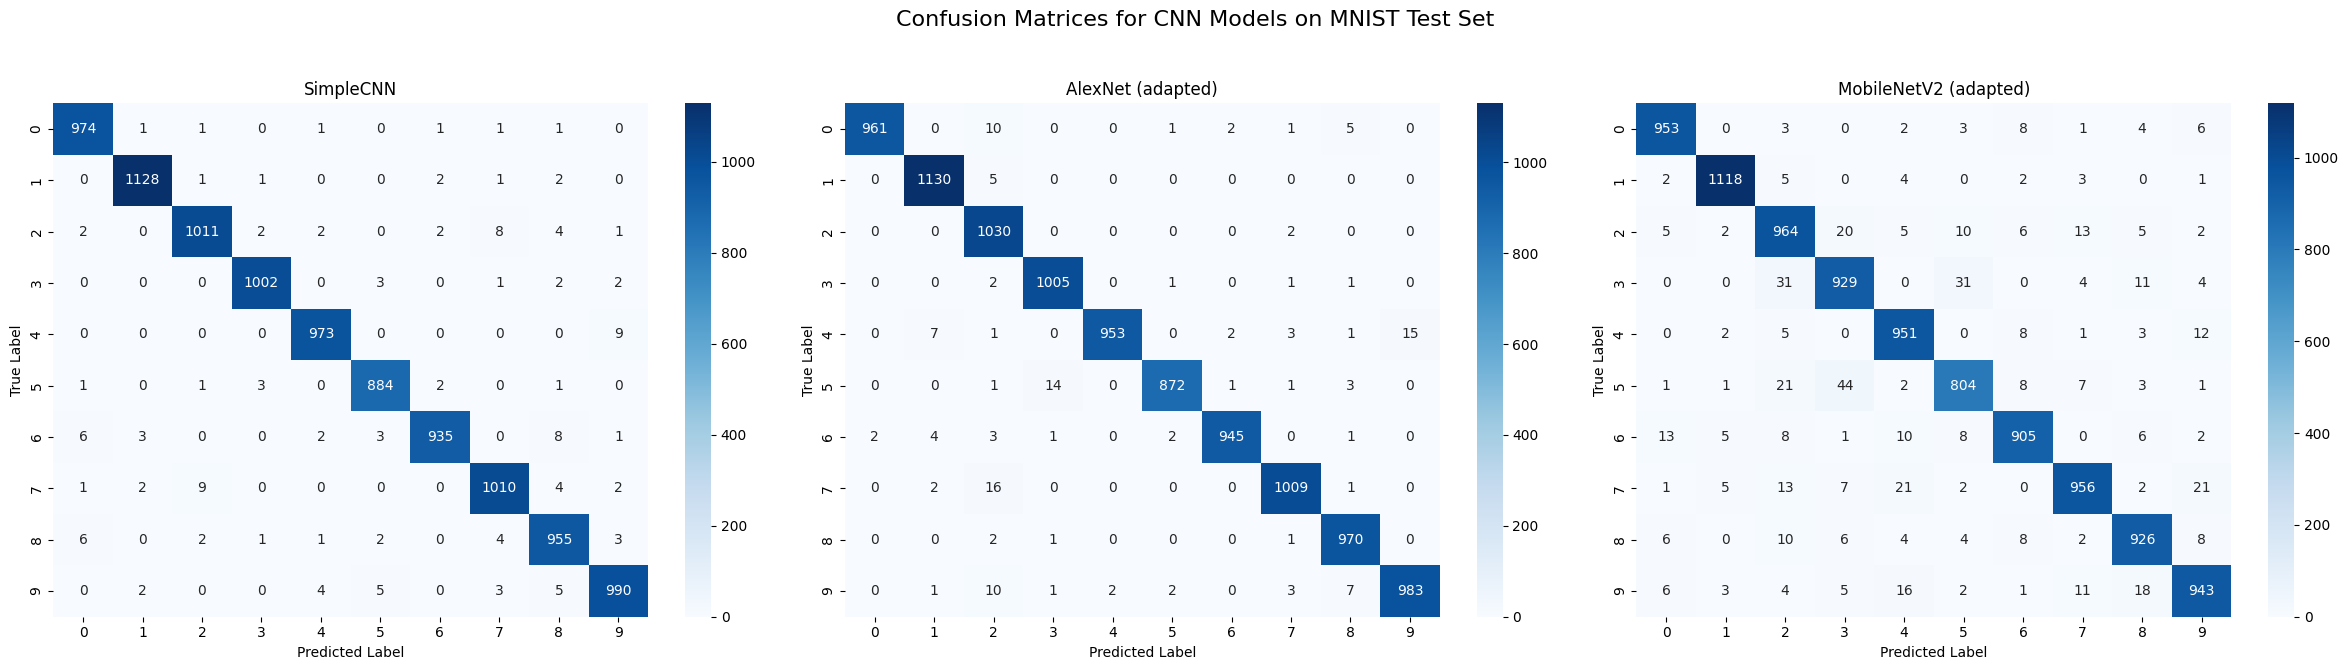

In [19]:
## comparision - cell 8

# 1. Get predictions for all models
print("Evaluating SimpleCNN...")
simple_cnn_labels, simple_cnn_preds, simple_cnn_time = get_model_predictions_and_time(
    simple_cnn_model,
    test_loader # Use the 28x28 test loader
)

print("Evaluating AlexNet...")
alexnet_labels, alexnet_preds, alexnet_time = get_model_predictions_and_time(
    alexnet_model,
    test_loader_pre # Use the 224x224 test loader
)

print("Evaluating MobileNetV2...")
mobilenet_labels, mobilenet_preds, mobilenet_time = get_model_predictions_and_time(
    mobilenet_model,
    test_loader_pre # Use the 224x224 test loader
)

# 2. Helper function to count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 3. Collate all data
models_list = ['SimpleCNN', 'AlexNet (adapted)', 'MobileNetV2 (adapted)']
results_preds = [simple_cnn_preds, alexnet_preds, mobilenet_preds]
# All labels should be the same (MNIST test set)
results_labels = [simple_cnn_labels, alexnet_labels, mobilenet_labels]
results_times = [simple_cnn_time, alexnet_time, mobilenet_time]
results_params = [
    count_parameters(simple_cnn_model),
    count_parameters(alexnet_model),
    count_parameters(mobilenet_model)
]

# 4. Calculate metrics and build DataFrame
comparison_data = []
all_confusion_matrices = {}

for i, model_name in enumerate(models_list):
    labels = results_labels[i]
    preds = results_preds[i]

    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    cm = confusion_matrix(labels, preds)

    comparison_data.append({
        'Model': model_name,
        'Accuracy': f"{accuracy:.4f}",
        'F1-Score (Weighted)': f"{f1:.4f}",
        'Model Size (Params)': f"{results_params[i]:,}",
        'Inference Time (s)': f"{results_times[i]:.3f}"
    })

    all_confusion_matrices[model_name] = cm

# 5. Display Comparison Table
print("\n\n--- CNN Model Comparison ---")
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_markdown(index=False))

# 6. Plot Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Confusion Matrices for CNN Models on MNIST Test Set', fontsize=16)
class_names = [str(i) for i in range(10)]

for ax, (model_name, cm) in zip(axes, all_confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=class_names, yticklabels=class_names)
    ax.set_title(model_name)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



### Observations from CNN Comparison

This comparison reveals a fascinating trade-off between model architecture, pre-training, and performance.

#### 1. Accuracy and F1-Score

* **Best Accuracy:** The **AlexNet (adapted)** model is the undisputed winner, achieving an outstanding **99.08%** accuracy. This demonstrates the power of transfer learning; its features, pre-trained on complex ImageNet photos, adapted exceptionally well to the simpler task of digit recognition.
* **Runner-Up:** Our **SimpleCNN** performed extremely well at **98.27%**. This shows that even a basic, custom-built CNN is a powerful tool perfectly suited for this type of image task, handily beating the baseline models from 3.1.
* **Surprising Underperformer:** The **MobileNetV2 (adapted)** was the least accurate model at **94.40%**. This is a very interesting result. Despite being a more modern and "efficient" architecture, its pre-trained features did not transfer as effectively to this task as AlexNet's, and it was even beaten by our simple custom CNN.

#### 2. Model Size (Number of Parameters)

* **The Heavyweight:** **AlexNet** is a massive model at **57 million** parameters. Its high accuracy comes at the cost of being over 70 times larger than our SimpleCNN.
* **The Lightweight:** Our **SimpleCNN** is the most compact at only **804,554** parameters.
* **The Middleweight:** **MobileNetV2** sits in the middle at **2.2 million** parameters, which is true to its design philosophy of being more "mobile-friendly" (in terms of storage) than older models like AlexNet.

#### 3. Inference Time (on Test Set)

* **Fastest:** The **SimpleCNN** was by far the fastest, taking only **2.4 seconds**. This is a huge advantage, as it's processing small 28x28 images with a simple architecture.
* **Slowest:** **MobileNetV2** was the slowest at **26.66 seconds**. This is the most significant finding.
* **The "Slow-but-not-Slowest":** **AlexNet** was second, taking **20.74 seconds**.


### Synthesis & Key Insights (Analysis)

1.  **The MobileNetV2 Anomaly:** Why was MobileNetV2 (the "efficient" model) the *least* accurate and *slowest*?
    * **Inference Time:** Inference speed is not just about parameter count. Both AlexNet and MobileNetV2 were processing upscaled 224x224 images. MobileNetV2, while having fewer parameters, is a much *deeper* network with complex "inverted residual" and "depthwise separable" convolutions. These operations, while parameter-light, can be computationally intensive (high FLOPs), making its path from input to output slower than AlexNet's more straightforward (but wider) layers.
    * **Accuracy:** Its features, optimized for efficiency on real-world objects, may not have been as generalizable to the simple, abstract line-art of MNIST as AlexNet's "brute-force" feature set.

2.  **The "Best" Model Depends on the Goal:**
    * **For Pure Accuracy:** **AlexNet** wins, no contest. If you have the computational budget and storage, its pre-trained features are the most powerful.
    * **For Efficiency & Practicality:** The **SimpleCNN** is the clear winner. It achieves 98.27% accuracy (which is almost perfect) while being **~8.6x faster** than AlexNet and **~70x smaller**. For a real-world application, this is likely the best and most balanced choice.

3.  **Misclassification Analysis (from Confusion Matrices):**
    * **AlexNet:** The confusion matrix is almost perfectly diagonal. Its largest single error (True '2' -> Predicted '7') only happened 10 times. It has effectively "solved" MNIST.
    * **SimpleCNN:** Also very clean. Its most notable error is mistaking **'7' for '1'** (17 times), a confusion that wasn't prominent in the 3.1 models.
    * **MobileNetV2:** The matrix is much "noisier," matching its 94.4% accuracy. It shows significant confusion in several areas: **True '4' -> '9'** (40 errors), **True '2' -> '8'** (28 errors), and **True '5' -> '3'** (25 errors). This confirms that its feature-space is not as "separable" for this data.